In [1]:
# Relevant imports
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Read the csv
df = pd.read_csv('COGSCI181 LLM Survey.csv')

# View the data
df.head(5)

,Timestamp,Rate how strongly you agree with any one of the following: [I personally know someone or have family/family friends who are successful in my field.],Rate how strongly you agree with any one of the following: [My academic background before attending university prepared me for success in my major.],Rate how strongly you agree with any one of the following: [Attending my university is not a huge financial burden for me.],The resources my courses provide are sufficient for me to succeed,"""PGO waves, or pontine-geniculate-occipital waves, are brief, high-amplitude electrical signals observed in the brain during REM sleep. These waves originate in the pons (part of the brainstem), propagate to the lateral geniculate nucleus (a visual relay center in the thalamus), and finally reach the occipital cortex (the visual processing area of the brain)...""","""Ponto-geniculo-occipital (PGO) waves are a signature of REM sleep. They represent the physiological mechanism of REM sleep that specifically limits the processing of external information. PGO waves look just like a message sent from the pons to the lateral geniculate nucleus of the visual thalamus, the occipital cortex, and other areas of the brain. The dedicated visual pathway of PGO waves can be interpreted by the brain as visual information, leading to the visual hallucinosis of dreams. PGO waves are considered to be both a reflection of REM sleep brain activity and causal to dreams due to their stimulation of the cortex…""","""REM sleep has many different brain features to it. The first of which is your electrical brain wave activity. The top of the brain, the cortex, looks almost identical to that which you have when you are awake, which is stunning because you are not conscious. You're lying completely still, no presence of muscle tone whatsoever, yet your brain seems to be just as on fire with electrical activity as it is when you are awake. Coming down a step, there are these unique pulses of electrical bursts that come up from the brain stem up to this sensory relay state center in the brain called the thalamus, and then they were initially recorded out in the back of the brain in the visual cortex. Hence these PGO waves describe the three sites that I just mentioned going from the brainstem, the pons, up to the thalamus, a part of it called the geniculate, and then out to the back of the brain called the occipital cortex, PGO…""","Resource A is officially recommended by the course instructor and staff, while Resource B is recommended by other students in the course, including people you know. Both have similar reviews. Which do you use?","For the past 6 months, which of the following resources are students utilizing most often to learn/complete their assignments and finding most reliable?",...,How comfortable or confident do you feel using the following resources to get answers to questions or complete an important assignment? [Internet Searches],How frequently on average do you use ChatGPT/similar AI tools in a week?,"How frequently on average do you use non-AI resources (office hours, google, course readings, etc) in comparison?","If you use ChatGPT/similar AI tools, what do you use it for?",Are you a student at UC Berkeley?,What year are you?,How old are you?,What gender do you identify with?,What college is your major(s) in?,What college is your minor in? (N/A if not applicable)
0,12/2/2024 21:37:07,Agree,Agree,Agree,3,Somewhat Credible,Somewhat Credible,Not Credible,Resource B,Internet Searches,...,Very Confident,3–4 times per week.,1,explanations of difficult concepts,Yes,UG Sophomore,18-19,nonbinary,College of Letters & Science,College of Letters & Science
1,12/2/2024 21:44:49,Strongly Agree,Strongly Agree,Agree,3,Very Credible,Very Credible,Somewhat Credible,Resource B,AI Tools (e.g. ChatGPT),...,Very Confident,3–4 times per week.,4,"Getting clarification for questions, helping w...",Yes,UG Sophomore,18-19,Male,College of Letters & Science,NaN
2,12/2/2024

In [5]:
# View the columns
df.columns

Index(['Timestamp',
       'Rate how strongly you agree with any one of the following: [I personally know someone or have family/family friends who are successful in my field.]',
       'Rate how strongly you agree with any one of the following: [My academic background before attending university prepared me for success in my major.]',
       'Rate how strongly you agree with any one of the following: [Attending my university is not a huge financial burden for me.]',
       'The resources my courses provide are sufficient for me to succeed',
       '"PGO waves, or pontine-geniculate-occipital waves, are brief, high-amplitude electrical signals observed in the brain during REM sleep. These waves originate in the pons (part of the brainstem), propagate to the lateral geniculate nucleus (a visual relay center in the thalamus), and finally reach the occipital cortex (the visual processing area of the brain)..."',
       '"Ponto-geniculo-occipital (PGO) waves are a signature of REM sleep. T

In [7]:
# Preprocess the data
# Map socioeconomic demographic variables to scores
columns_to_replace = ['Rate how strongly you agree with any one of the following: [My academic background before attending university prepared me for success in my major.]']
replacement_dict ={'Strongly Disagree': -2, 'Disagree': -1, 'Neutral': 0, 'Agree': 1, 'Strongly Agree': 2}
df[columns_to_replace] = df[columns_to_replace].replace(replacement_dict)
know_someone = ['Rate how strongly you agree with any one of the following: [I personally know someone or have family/family friends who are successful in my field.]']
df[know_someone] = df[know_someone].replace(replacement_dict)
finan_burden = ['Rate how strongly you agree with any one of the following: [Attending my university is not a huge financial burden for me.]']
df[finan_burden] = df[finan_burden].replace(replacement_dict)

# Map resource needs
columns_to_replace = ['The resources my courses provide are sufficient for me to succeed']
replacement_dict = {1: 2, 2: 1, 3: 0, 4: -1, 5: -2}
df[columns_to_replace] = df[columns_to_replace].replace(replacement_dict)

# Map PGO resource credibility
columns_to_replace = [column for column in df.columns if 'PGO' in column]
replacement_dict ={'Not Credible': 0, 'Likely Not Credible': 1, 'Somewhat Credible': 2, 'Very Credible': 3}
df[columns_to_replace] = df[columns_to_replace].replace(replacement_dict)
for col in columns_to_replace:
    if "stunning" in col:
        df.rename(columns={col:"scientist_credibility_category"}, inplace=True)

# Binarize hypothetical resource selection
column_to_encode = [column for column in df.columns if 'Resource A' in column]
df['chooses_peers_recs'] = [1 if 'Resource B' in value else 0 for value in df[column_to_encode[0]]]
df = df.drop(columns=column_to_encode)

# Binarize most reliable
column_to_encode = [column for column in df.columns if 'most reliable' in column]
df['chooses_AI_as_reliable'] = [1 if 'AI' in value else 0 for value in df[column_to_encode[0]]]
df = df.drop(columns=column_to_encode)

# Binarize approach
column_to_encode = [column for column in df.columns if 'approach' in column]
df['values_effort'] = [1 if 'thoroughness' in value else 0 for value in df[column_to_encode[0]]]
df = df.drop(columns=column_to_encode)

# Map confidence/comfort questions to scores
confidence_columns = [column for column in df.columns if 'comfortable or confident' in column]
confidence_mapping = {
    "Very Hesitant": -2,
    "Somewhat Hesitant": -1,
    "Neutral": 0,
    "Somewhat Confident": 1, 
    "Very Confident": 2
}
for col in confidence_columns:
    if 'Select' in col:
        df[col] = [1 if "Somewhat Hesitant" in value else 0 for value in df[col]]
    else:
        df[col] = df[col].map(confidence_mapping)

# Map categorical GPT usage to scores
another_dict = {"I don’t use ChatGPT.": 0, 'Less than once a week.': 1, '1–2 times per week.': 2, '3–4 times per week.' : 3, 'Once a day (7 times per week).': 7, '2–3 times a day (14–21 times per week).': 14, '4–5 times a day (28–35 times per week).' : 28, 'More than 5 times a day (35+ times per week).' : 36}
replace_gptuse = ['How frequently on average do you use ChatGPT/similar AI tools in a week?']
df[replace_gptuse] = df[replace_gptuse].replace(another_dict)

# Map non-AI comparison
another_dict = {1: -2, 2: -1, 3: 0, 4: 1, 5: 2}
replace_nongptuse = [column for column in df.columns if 'non-AI' in column]
df[replace_nongptuse] = df[replace_nongptuse].replace(another_dict)

In [9]:
# Rename the columns
df.rename(columns={
    "Rate how strongly you agree with any one of the following: [I personally know someone or have family/family friends who are successful in my field.]": "network_connectivity",
    "Rate how strongly you agree with any one of the following: [My academic background before attending university prepared me for success in my major.]": "academic_preparedness",
    "Rate how strongly you agree with any one of the following: [Attending my university is not a huge financial burden for me.]": "financial_comfort",
    "The resources my courses provide are sufficient for me to succeed": "needs_outside_resources",
    '"PGO waves, or pontine-geniculate-occipital waves, are brief, high-amplitude electrical signals observed in the brain during REM sleep. These waves originate in the pons (part of the brainstem), propagate to the lateral geniculate nucleus (a visual relay center in the thalamus), and finally reach the occipital cortex (the visual processing area of the brain)..."': "gpt_credibility_category",
    '"Ponto-geniculo-occipital (PGO) waves are a signature of REM sleep. They represent the physiological mechanism of REM sleep that specifically limits the processing of external information. PGO waves look just like a message sent from the pons to the lateral geniculate nucleus of the visual thalamus, the occipital cortex, and other areas of the brain. The dedicated visual pathway of PGO waves can be interpreted by the brain as visual information, leading to the visual hallucinosis of dreams. PGO waves are considered to be both a reflection of REM sleep brain activity and causal to dreams due to their stimulation of the cortex…"': "research_credibility_category",
    "How comfortable or confident do you feel using the following resources to get answers to questions or complete an important assignment?  [Professor/Course staff]": "staff_comfort",
    "How comfortable or confident do you feel using the following resources to get answers to questions or complete an important assignment?  [Peers]": "peer_comfort",
    "How comfortable or confident do you feel using the following resources to get answers to questions or complete an important assignment?  [Select \"Somewhat Hesitant\" for this option to show you are attentive]": "attention_check",
    "How comfortable or confident do you feel using the following resources to get answers to questions or complete an important assignment?  [Ed Discussion Boards]": "ed_comfort",
    "How comfortable or confident do you feel using the following resources to get answers to questions or complete an important assignment?  [AI tools (e.g., ChatGPT)]": "ai_comfort",
    "How comfortable or confident do you feel using the following resources to get answers to questions or complete an important assignment?  [Internet Searches]": "searches_comfort",
    "How frequently on average do you use ChatGPT/similar AI tools in a week?": "reported_gpt_use",
    "How frequently on average do you use non-AI resources (office hours, google, course readings, etc) in comparison?": "reported_gpt_use_over_nonai",
    "If you use ChatGPT/similar AI tools, what do you use it for?": "gpt_purpose",
    "Are you a student at UC Berkeley?": "student",
    "What year are you?": "academic_year",
    "How old are you?": "age",
    "What gender do you identify with?": "gender",
    "What college is your major(s) in?": "major_college",
    "What college is your minor in? (N/A if not applicable)": "minor_college"
    }, inplace=True)
df.head(5)

,Timestamp,network_connectivity,academic_preparedness,financial_comfort,needs_outside_resources,gpt_credibility_category,research_credibility_category,scientist_credibility_category,staff_comfort,peer_comfort,...,gpt_purpose,student,academic_year,age,gender,major_college,minor_college,chooses_peers_recs,chooses_AI_as_reliable,values_effort
0,12/2/2024 21:37:07,1,1,1,0,2,2,0,1,-1,...,explanations of difficult concepts,Yes,UG Sophomore,18-19,nonbinary,College of Letters & Science,College of Letters & Science,1,0,1
1,12/2/2024 21:44:49,2,2,1,0,3,3,2,1,2,...,"Getting clarification for questions, helping w...",Yes,UG Sophomore,18-19,Male,College of Letters & Science,NaN,1,1,1
2,12/2/2024 22:32:27,1,1,0,2,3,3,0,-1,2,...,I use it to find my errors and to explain to m...,Yes,UG Sophomore,18-19,Male,"College of Letters & Science, Computing, Data ...",NaN,1,1,1
3,12/3/2024 0:09:06,2,1,1,-1,3,3,2,1,1,...,NaN,Yes,UG Sophomore,18-19,Female,College of Letters & Science,NaN,1,1,1
4,12/3/2024 0:20:21,-2,-2,0,1,2,2,1,0,-2,...,"General guidance, and clarifying conceptual qu...",Yes,UG Senior,30+,Male,"Computing, Data Science, & Society (CDSS)",NaN,0,0,1


In [11]:
# Drop non-students and non-attentive
df = df[df['student'] == 'Yes']
#df = df[df['attention_check'] == 1]

print("UC Berkeley class and college distributions were unaccessible.")
print()

# Assess age representation
berkeley_age_dist = pd.Series({
    '20-21': 30.07,
    '18-19': 28.76,
    '22-24': 15.59,
    '25-29': 14.74,
    '30+': 9.27
    })
counts = df['age'].value_counts(normalize=True)
counts = counts.apply(lambda x: round(x * 100))
counts.rename(index={'22-23': '22-24', '26-29': '25-29'}, inplace=True)
age_df = pd.concat([berkeley_age_dist, counts], axis=1, keys=['UC Berkeley Age', 'Participants Age'])

print(age_df)
print(f"UC Berkeley average age: {berkeley_age_dist.mean()}. Participant average age: {counts.mean()}.")

# Assess gender representation
counts = df['gender'].value_counts(normalize=True)
print()
print("UC Berkeley male:female:other distribution is 43:55:2.")
print(f"Participant gender distribution is {counts['Male']*100:.0f}:{counts['Female']*100:.0f}:{counts['nonbinary']*100:.0f}")

UC Berkeley class and college distributions were unaccessible.

       UC Berkeley Age  Participants Age
20-21            30.07                43
18-19            28.76                36
22-24            15.59                 7
25-29            14.74                 4
30+               9.27                11
UC Berkeley average age: 19.686. Participant average age: 20.2.

UC Berkeley male:female:other distribution is 43:55:2.
Participant gender distribution is 39:57:4


Text(0, 0.5, 'Counts')

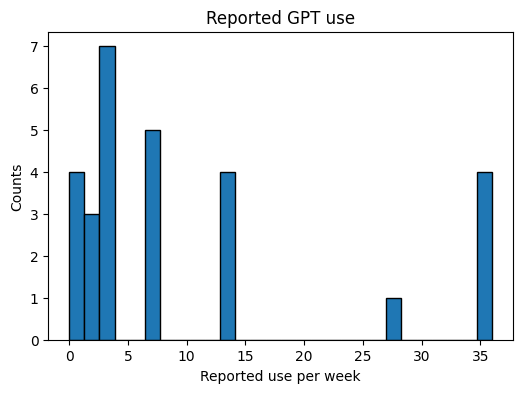

In [13]:
# Histogram of outcomes
plt.figure(figsize=(6,4))
plt.hist(x=df['reported_gpt_use'], bins=28, edgecolor='black')
plt.title("Reported GPT use")
plt.xlabel("Reported use per week")
plt.ylabel("Counts")

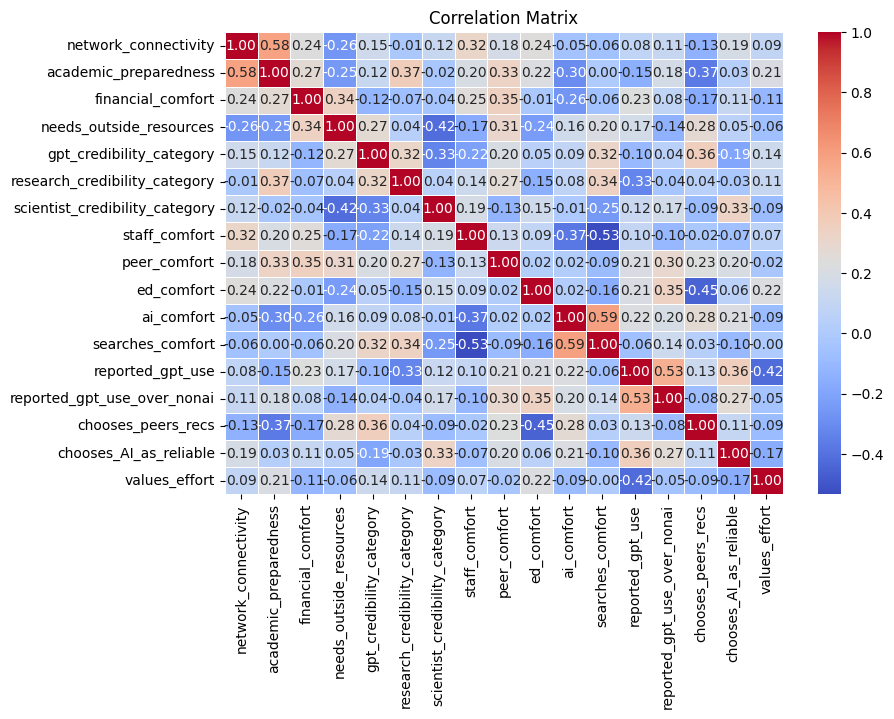

In [15]:
# Grab predictors
predictors = [
    'network_connectivity',
    'academic_preparedness', 
    'financial_comfort',
    'needs_outside_resources',
    'gpt_credibility_category',
    'research_credibility_category',
    'scientist_credibility_category',
    'staff_comfort',
    'peer_comfort',
    'ed_comfort', 
    'ai_comfort', 
    'searches_comfort',
    'reported_gpt_use', 
    'reported_gpt_use_over_nonai', 
    'chooses_peers_recs',
    'chooses_AI_as_reliable',
    'values_effort'
    ]
prediction_df = df[predictors]
correlations = prediction_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(9, 6))  # Adjust the size as needed
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

In [17]:
# Understand distribution of interesting variables and descriptive statistics
descriptive_stats = df.describe()
descriptive_stats

,network_connectivity,academic_preparedness,financial_comfort,needs_outside_resources,gpt_credibility_category,research_credibility_category,scientist_credibility_category,staff_comfort,peer_comfort,attention_check,ed_comfort,ai_comfort,searches_comfort,reported_gpt_use,reported_gpt_use_over_nonai,chooses_peers_recs,chooses_AI_as_reliable,values_effort
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.107143,0.714286,0.642857,0.000000,2.285714,2.142857,1.285714,0.571429,0.821429,0.928571,0.750000,0.535714,1.142857,10.428571,-0.250000,0.642857,0.571429,0.750000
std,1.663091,1.212806,1.129218,1.360828,0.599824,0.755929,0.975900,1.288944,1.055973,0.262265,1.265643,1.201300,0.931518,12.215438,1.377733,0.487950,0.503953,0.440959
min,-2.000000,-2.000000,-2.000000,-2.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000,-2.000000,-2.000000,-1.000000,0.000000,-2.000000,0.000000,0.000000,0.000000
25%,-2.000000,0.000000,0.000000,-1.000000,2.000000,2.000000,0.750000,-0.250000,0.750000,1.000000,0.000000,-0.250000,1.000000,2.750000,-2.000000,0.000000,0.000000,0.750000
50%,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,1.250000,1.000000,3.000000,3.000000,2.000000,2.000000,1.250000,1.000000,2.000000,1.250000,2.000000,14.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,36.000000,2.000000,1.000000,1.000000,1.000000


In [26]:
df['gpt_purpose']

0                   explanations of difficult concepts 
1     Getting clarification for questions, helping w...
2     I use it to find my errors and to explain to m...
3                                                   NaN
4     General guidance, and clarifying conceptual qu...
5     as a person named vincent p. i use it for code...
6     Understand course content, do calculations, ge...
7                     bs assignments i don't want to do
8                                Homework and concepts 
10    Help organize thought or break down an explana...
11                  Brainstorming, revising, explaining
12    general questions, assignments, recommendation...
13    Google is starting to automatically generate s...
14    Searching up terms based on description, doing...
15                     Creating a study schedule for me
16          searching up basic definitions/explanations
17    Explain/breakdown concepts I don’t understand,...
18                                              

In [19]:
# Perform regression analysis for overall gpt use
X = prediction_df.drop(columns=['reported_gpt_use', 'reported_gpt_use_over_nonai'])
y = prediction_df['reported_gpt_use']

X_sm = sm.add_constant(X) 
ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       reported_gpt_use   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     1.194
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.384
Time:                        15:08:55   Log-Likelihood:                -96.513
No. Observations:                  28   AIC:                             225.0
Df Residuals:                      12   BIC:                             246.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

The results suggest the variables provided have poor predictive power. We'll investigate which ones are the poorest predictors and remove them by analyzing linearity, correlation, p-values, and multicollinearity.

/root/venv/lib/python3.9/site-packages/statsmodels/graphics/regressionplots.py:566: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


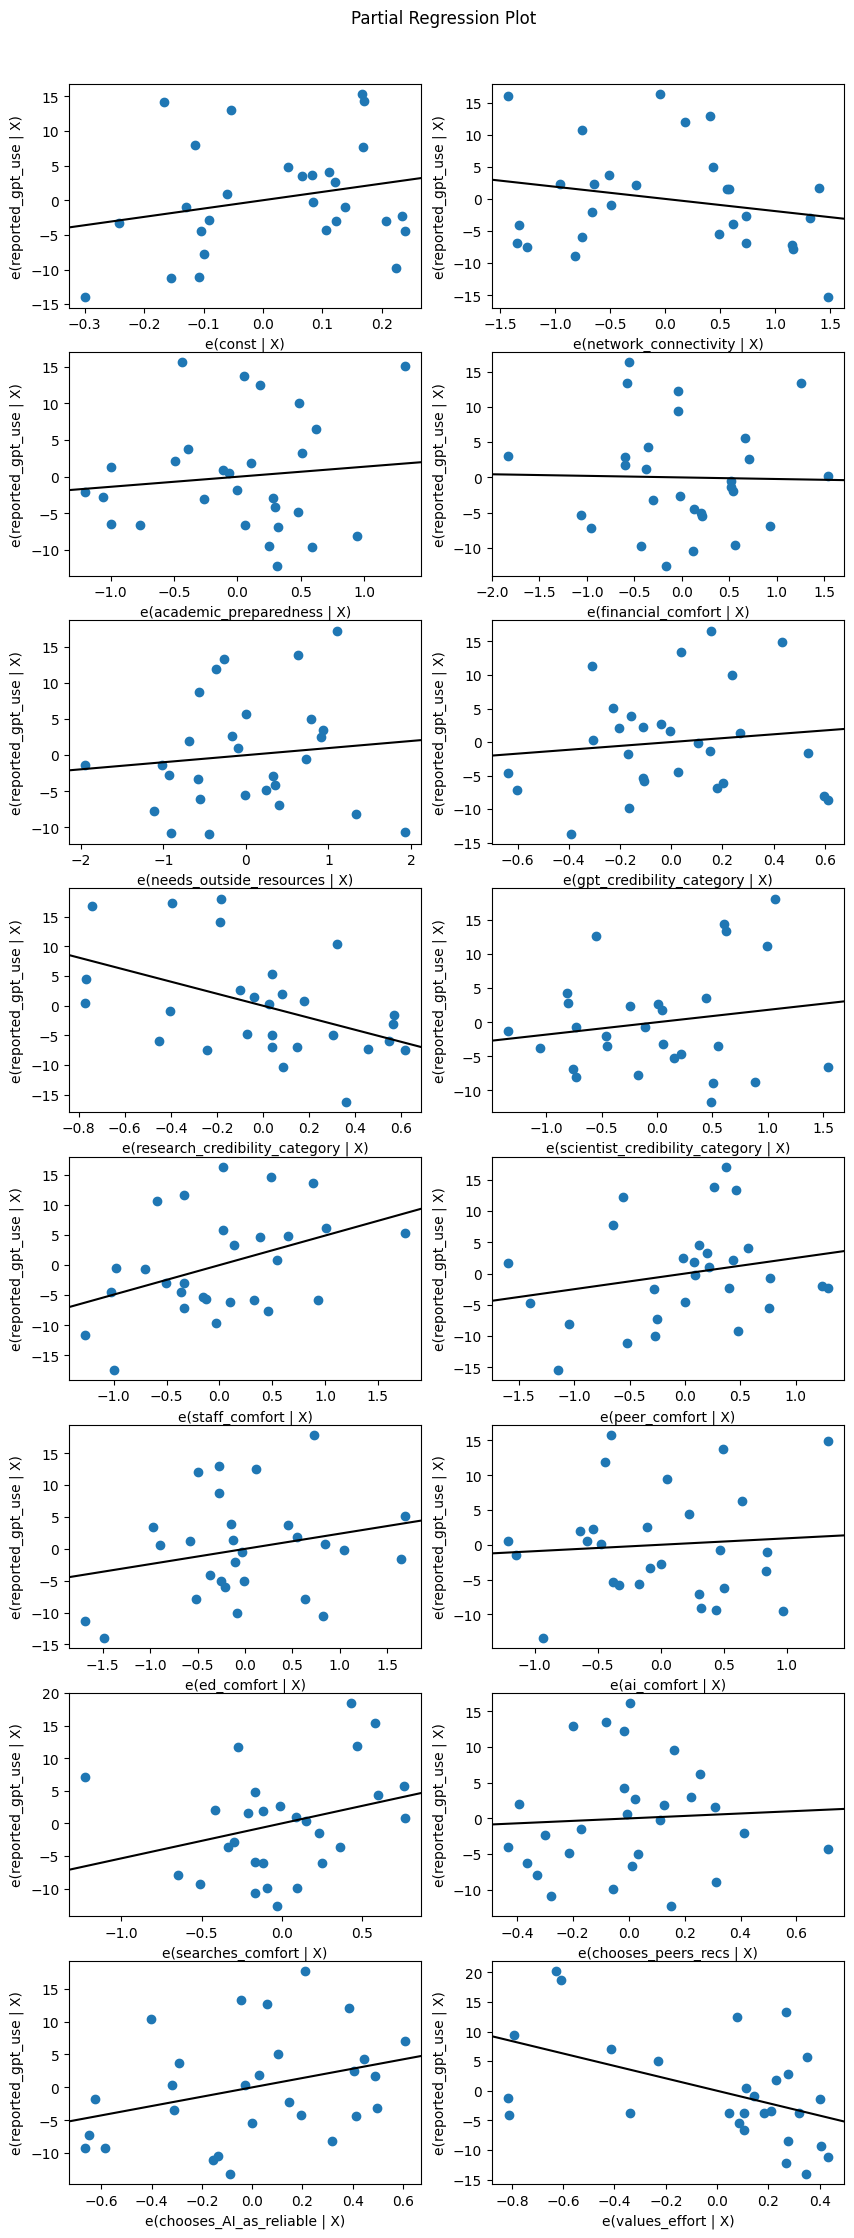

In [23]:
# Partial residual plots, or added-variable plots, looking for linearity and if a relationship
fig = sm.graphics.plot_partregress_grid(ols_model)
fig.set_size_inches(10, 25)
plt.show()

In [24]:
# Perform multicollinearity checks, VIF values over 10 suggest significant collinearity
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,Variable,VIF
0,network_connectivity,2.805272
1,academic_preparedness,5.194702
2,financial_comfort,2.931867
3,needs_outside_resources,2.235972
4,gpt_credibility_category,30.884008
5,research_credibility_category,33.157629
6,scientist_credibility_category,4.907922
7,staff_comfort,3.664675
8,peer_comfort,3.508143
9,ed_comfort,3.297161


In [13]:
# Drop irrelevant and redundant variables. Irrelevant vars are defined insignificant (>0.20 relaxed p-value) and low correlation (<0.30) assessed at a linear relationship.
irrelevant_and_redundant = [
    'network_connectivity',
    'academic_preparedness',
    'financial_comfort',
    'needs_outside_resources',
    'gpt_credibility_category',
    'scientist_credibility_category',
    'peer_comfort',
    'ed_comfort',
    'ai_comfort',
    'searches_comfort',
    'chooses_peers_recs'
]

# Perform regression analysis w/ most relevant features only
X = prediction_df.drop(columns=(['reported_gpt_use', 'reported_gpt_use_over_nonai'] + irrelevant_and_redundant))
y = prediction_df['reported_gpt_use']

X_sm = sm.add_constant(X) 
ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       reported_gpt_use   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     3.469
Date:                Fri, 20 Dec 2024   Prob (F-statistic):             0.0234
Time:                        01:32:38   Log-Likelihood:                -102.69
No. Observations:                  28   AIC:                             215.4
Df Residuals:                      23   BIC:                             222.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [14]:
# Run Variance Inflation Factor check
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,Variable,VIF
0,research_credibility_category,4.482366
1,staff_comfort,1.234812
2,chooses_AI_as_reliable,2.013399
3,values_effort,3.340994


The R-squared value suggests that this model explains 37.6% of the variance in reported gpt. This means that the selected heuristics provide some predictive power of gpt use. The lower adj. r-squared value is common, this difference is likely partly due to correlations between staff_comfort and other variables. Staff comfort had a p-value above our threshold, but due to its correlation with search and ai comfort, it offers some explanatory value. The F-statistic validates that at least one heuristic selected for this model is statistically significant and that the model itself is statistically significant. The log-likelihood and AIC validate that the model with removed features performs better. VIF check confirms that each final predictor offers independent explainability to our response variable.

In [15]:
residuals = ols_model.resid
predicted = ols_model.fittedvalues

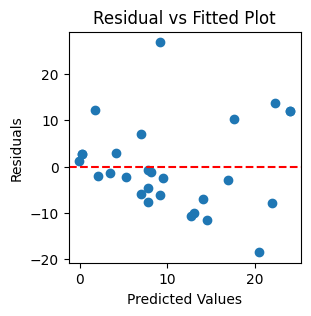

In [16]:
# Plot residuals vs predicted values
plt.figure(figsize=(3, 3))
plt.scatter(predicted, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at 0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual vs Fitted Plot')
plt.show()

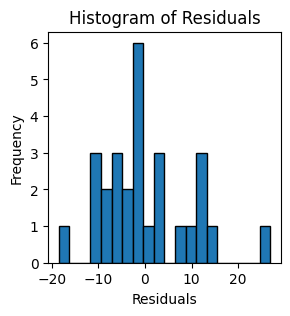

In [17]:
# View distribution
plt.figure(figsize=(3, 3))
plt.hist(residuals, bins=20, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [18]:
# Cross validate the best model
test_model = LinearRegression()
scores = cross_val_score(test_model, X, y, cv=5, scoring='neg_mean_squared_error')  # Use 5-fold cross-validation
mean_score = np.mean(np.sqrt(-scores))
print(f"Mean Cross-Validation Score (RMSE): {mean_score}")

Mean Cross-Validation Score (RMSE): 11.41707272152035


In [19]:
# Perform regression analysis for predicting gpt use bias
X = prediction_df.loc[:, ['ed_comfort', 'peer_comfort']]
y = prediction_df['reported_gpt_use_over_nonai']

X_sm = sm.add_constant(X) 
ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:     reported_gpt_use_over_nonai   R-squared:                       0.204
Model:                                     OLS   Adj. R-squared:                  0.141
Method:                          Least Squares   F-statistic:                     3.212
Date:                         Fri, 20 Dec 2024   Prob (F-statistic):             0.0574
Time:                                 01:32:38   Log-Likelihood:                -44.992
No. Observations:                           28   AIC:                             95.98
Df Residuals:                               25   BIC:                             99.98
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [20]:
# Run Variance Inflation Factor check to make sure finalized columns do not display multicollinearity
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,Variable,VIF
0,ed_comfort,1.126217
1,peer_comfort,1.126217


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6b9c6c4-ec4a-491e-ae33-581131c8d8d8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>